# ISLR-Python Ch 5: Applied 5

- [Load Default Dataset](#Load-Default-Dataset)
- [A. Build Logistic Model of Credit Card Default](#A.-Build-Logistic-Model-of-Credit-Card-Default)
- [B-C. Use Validation Set Approach to Estimate Test Error](#B-C.-Use-Validation-Set-Approach-to-Estimate-Test-Error)
- [D. Include Student Status in Model](#D.-Include-Student-Status-in-Model)

In [1]:
## perform imports and set-up
import numpy as np
import pandas as pd
import statsmodels.api as sm

from matplotlib import pyplot as plt

%matplotlib inline
plt.style.use('ggplot') # emulate pretty r-style plots

# print numpy arrays with precision 4
np.set_printoptions(precision=4)

## Load Default Dataset 

In [2]:
df = pd.read_csv('../../../data/Default.csv',index_col=0)
# add new column for binary default
df['default01'] = df.default=='Yes'
print(len(df))
df.head()

10000


,default,student,balance,income,default01
1,No,No,729.526495,44361.625074,False
2,No,Yes,817.180407,12106.134700,False
3,No,No,1073.549164,31767.138947,False
4,No,No,529.250605,35704.493935,False
5,No,No,785.655883,38463.495879,False


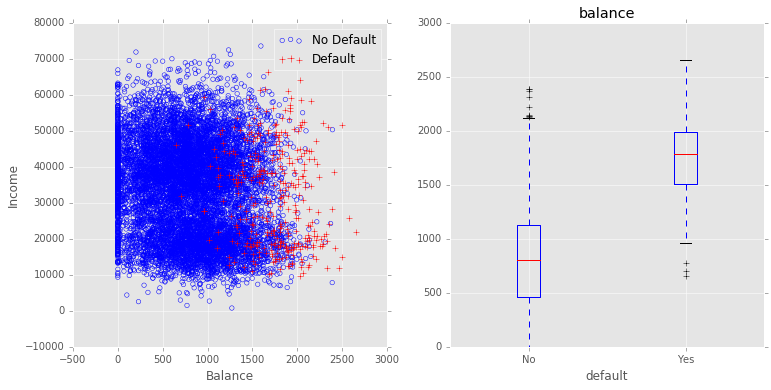

In [3]:
# Lets make a few plots of the data to remind ourselves 
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

# Scatter the defaulters and non-defaulters in different marker styles across balances and incomes
ax1.scatter(df[df.default=='No'].balance.values,df[df.default=='No'].income.values, facecolors='none',
           edgecolors='b',label = 'No Default');
ax1.scatter(df[df.default=='Yes'].balance.values,df[df.default=='Yes'].income.values, marker='+', c='r',
           s = 40, label='Default');
ax1.set_xlabel('Balance')
ax1.set_ylabel('Income')
ax1.legend(loc='best');

# since it looks like defaulters carray a higher balance boxplot by grouping default status
df.boxplot(['balance'], by='default', ax=ax2);
fig.suptitle(''); # remove pandas auto title

From the above plots we can see that individuals with higher credit card balances are more likely to default than individuals with lower credit card balances. This appears to be independent of the individuals income. We are going to make a logistic regression model to classify whether an individual will default given their income and credit card balance.

## A. Build Logistic Model of Credit Card Default

In [4]:
# Design matrix and response #
##############################
predictors = ['balance','income']
X = sm.add_constant(df[predictors])
y = [1 if el == 'Yes' else 0 for el in df.default.values]

# Build Classifier and Fit #
############################
model = sm.Logit(y,X)
logit = model.fit()
print(logit.summary())

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Wed, 27 Jul 2016   Pseudo R-squ.:                  0.4594
Time:                        08:53:36   Log-Likelihood:                -789.48
converged:                       True   LL-Null:                       -1460.3
                                        LLR p-value:                4.541e-292
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -11.5405      0.435    -26.544      0.000       -12.393   -10.688
balance        0.0056      0

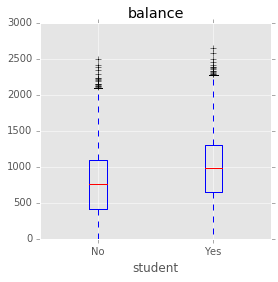

In [5]:
# Interestingly in the above we find that income is significant. Why is this? The plot below shows that balance and
# student status are related. Students carry a higher balance. Also in the text we saw students are less likely to 
# default than non students who hold the same balance. So the income variable is significant only because we haven't 
# accounted for student status in the model.
fig, ax = plt.subplots(figsize=(4,4))
df.boxplot(['balance'], by='student', ax = ax);
fig.suptitle('');

## B-C. Use Validation Set Approach to Estimate Test Error 

In [9]:
def logistic_validation_error(dataFrame, quantitave_predictors, response):
    """
    Returns the Validation Set Approach Error rate for a logistic model applied to quantitaive predictors and 
    response in dataframe.
    """
    # Split the data into training and validation sets #
    ####################################################
    # split the data set into roughly two equal sets
    indices = np.random.choice([True, False], size=len(dataFrame), replace=True)
    training = df[indices]
    validation = df[~indices]

    # Fit Logistic on Training Set #
    ################################
    X_train = sm.add_constant(training[predictors])
    y_train = [1 if el=='Yes' else 0 for el in training[response].values]
    
    X_validation = sm.add_constant(validation[predictors])
    y_validation = [1 if el=='Yes' else 0 for el in validation[response].values]

    train_model = sm.Logit(y_train,X_train)
    train_logit = train_model.fit()

    # Compare Predictions with Validation Set #
    ###########################################
    # get the predicted responses posterior probability using a 0.5 threshold
    y_predicted = np.array(train_logit.predict(X_validation) > 0.5, dtype=float)

    error_rate = np.mean(y_predicted != y_validation)
    
    return error_rate

# Compute MSE using Validation Approach for Three Splits #
##########################################################
validation_error = np.array([])
for i in range(1,4):
    # set the random seed to different values so we get different splits of the data
    np.random.seed(i)
    # call logistic_validation_mse function
    validation_error = np.append(validation_error, logistic_validation_error(df,['balance', 'income'], ['default']))
    
print('Error_Rate =', validation_error)

Optimization terminated successfully.
         Current function value: 0.083466
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.076237
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.070528
         Iterations 10
Error_Rate = [ 0.0254  0.0285  0.0302]


As expected with each split we get a slight different MSE estimate. It is not extremely variable though because the data set is somewhat large 10000 observations.

## D. Include Student Status in Model

In [8]:
# Convert Student Status to Dummy Variable #
############################################
# make a dataframe of student status
student_status = pd.get_dummies(df['student'])

# Create Design Matrix #
########################
predictors = ['balance','income']
# Join the student status to the dataframe ( we drop the reference No=0)
X = sm.add_constant(df[predictors].join(student_status.ix[:,'Yes']))
print(X.head(),'\n')
y = df['default01']

# Split Data into Train/Validate Sets #
#######################################
indices = np.random.choice([True, False], size=len(df), replace=True)

X_train = X[indices]
y_train = y[indices]
X_validation = X[~indices]
y_validation = y[~indices]

# Create Logistic Model #
#########################
train_logit = sm.Logit(y_train,X_train).fit()
print(train_logit.summary())

# Compute MSE #
###############
y_predicted = np.array(train_logit.predict(X_validation) > 0.5, dtype=float)

error_rate = np.mean(y_predicted != y_validation)

print('\nThe Error Rate including student status = ', error_rate)

   const      balance        income  Yes
1      1   729.526495  44361.625074    0
2      1   817.180407  12106.134700    1
3      1  1073.549164  31767.138947    0
4      1   529.250605  35704.493935    0
5      1   785.655883  38463.495879    0 

Optimization terminated successfully.
         Current function value: 0.076483
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:              default01   No. Observations:                 4923
Model:                          Logit   Df Residuals:                     4919
Method:                           MLE   Df Model:                            3
Date:                Wed, 27 Jul 2016   Pseudo R-squ.:                  0.4860
Time:                        08:54:59   Log-Likelihood:                -376.52
converged:                       True   LL-Null:                       -732.56
                                        LLR p-value:                5.083e-154
                 

As expected the student status and not the income is significant, though it is weakly significant so we see little change in the MSE.